In [1]:
from spkit import pfa
import pandas as pd
import re
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pickle

In [2]:
%load_ext autoreload

In [3]:
%autoreload 0

In [4]:
%aimport spkit.pfa

In [5]:
folder = 'data/kdd/2005-2006'

Save data

In [6]:
with open('%s/kdd_2005_2005_df.pkl' % folder, 'rb') as pklfile:
    df = pickle.load(pklfile)
with open('%s/kdd_2005_2005_q_matrix.pkl' % folder, 'rb') as pklfile:
    q_matrix = pickle.load(pklfile)

In [ ]:
df.shape

In [7]:
q_matrix.shape

(176630, 110)

### Fitting data

In [ ]:
%%time
# Data matrix
data = df[['Correct First Attempt', 'Anon Student Id', 'question_id']].values.tolist()

# Instantiate model
model = pfa.PFA()
model.fit(data, q_matrix, penalty='elasticnet', l1_ratio='0.001', solver='saga')

In [ ]:
students = df['Anon Student Id'].unique().tolist()
len(students)

In [ ]:
with open('%s/kdd_2005_2005_students.pkl' % folder, 'wb') as pklfile:
    pickle.dump(students, pklfile)
with open('%s/kdd_2005_2005_model.pkl' % folder, 'wb') as pklfile:
    pickle.dump(model, pklfile)

In [47]:
%%time
data_arr = np.asarray(data)
rmse = 0
n = 0
score_df = []
learning_state = {}
outcome_all = []
predicted_proba = []
for student in students:
    student_idx = np.where(data_arr[:,1] == student)
    outcome = data_arr[student_idx, 0].astype('int64')
    outcome_all += outcome.tolist()[0]
    question_id = data_arr[student_idx, 2].astype('int64')
    data_student = np.vstack((outcome, question_id)).T.astype('int64').tolist()
    predicted = model.predict_proba(data_student, q_matrix)
    predicted_proba += predicted[:,1].tolist()
    s_ll, s_aic, s_bic, s_rmse, s_acc = model.score()
    fpr, tpr, _ = roc_curve(outcome.flatten(), predicted[:,1], pos_label=1)
    auc_score = auc(fpr, tpr)
    score_df.append({"student": student,
                     "AIC": s_aic,
                     "BIC": s_bic,
                     "RMSE": s_rmse,
                     "Acc": s_acc,
                     "n questions": model.n_questions,
                     "LL": s_ll,
                     "correct_outcome": np.where(outcome == 1)[1].shape[0],
                     "incorrect_outcome": np.where(outcome == 0)[1].shape[0],
                     "AUC": auc_score})
    learning_state[student] = model.learning_state

CPU times: user 55.7 s, sys: 100 ms, total: 55.8 s
Wall time: 55.8 s


In [43]:
score = pd.DataFrame.from_dict(score_df)

In [49]:
with open('%s/kdd_2005_2005_score.pkl' % folder, 'wb') as pklfile:
    pickle.dump(score, pklfile)
with open('%s/kdd_2005_2005_learning_state.pkl' % folder, 'wb') as pklfile:
    pickle.dump(learning_state, pklfile)

In [20]:
rmse_train = np.sqrt((score['RMSE']**2*score['n questions']).sum()/score['n questions'].sum())
rmse_avg = score['RMSE'].mean()
rmse_std = score['RMSE'].std()

In [21]:
print("RMSE de treino: %.2f" % rmse_train)
print("RMSE médio: %.2f +- %.2f" % (rmse_avg, rmse_std))

RMSE de treino: 0.41
RMSE médio: 0.43 +- 0.05


In [22]:
acc_train = (score['Acc']*score['n questions']).sum()/score['n questions'].sum()
acc_avg = score['Acc'].mean()
acc_std = score['Acc'].std()

In [23]:
print("Acc de treino: %.2f" % acc_train)
print("Acc médio: %.2f +- %.2f" % (acc_avg, acc_std))

Acc de treino: 0.75
Acc médio: 0.69 +- 0.12


In [34]:
fpr, tpr, thresholds = roc_curve(outcome_all, predicted_proba, pos_label=1)
auc_score = auc(fpr, tpr)
auc_avg = score['AUC'].mean()
auc_std = score['AUC'].std()

# Sensitivity = tpr = TP/(TP+FN)
# Specificity = 1-fpr = TN/(TN+FP)
# Youden's index = Sensitivity + Specificity - 1 = tpr + (1-fpr) - 1 = tpr - fpr
J_stats = tpr - fpr
J_opt_thresholds = thresholds[np.argmax(J_stats)]
print('Youden\'s optimum threshold: %.2f' % J_opt_thresholds)

Youden's optimum threshold: 0.73


In [25]:
print("AUC de treino: %.2f" % auc_score)
print("AUC médio: %.2f +- %.2f" % (auc_avg, auc_std))

AUC de treino: 0.73
AUC médio: 0.69 +- 0.09


Recalculating accuracy after adjusting cutoff point with Youden's Index

In [27]:
estimated_outcome = np.where(np.asarray(predicted_proba) > J_opt_thresholds, 1, 0)
acc = (estimated_outcome == np.asarray(outcome_all)).sum()/score['n questions'].sum()
acc

0.6976681355792596

In [28]:
# Save threshold
with open('%s/kdd_2005_2005_threshold.pkl' % folder, 'wb') as pklfile:
    pickle.dump(J_opt_thresholds, pklfile)

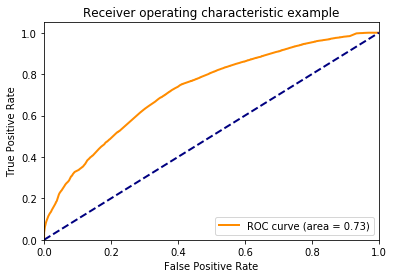

In [29]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Comparing accuracy to random baseline

In [35]:
n_questions = score['n questions'].sum()
p = score['correct_outcome'].sum()/n_questions
# Save p
with open('%s/kdd_2005_2005_p.pkl' % folder, 'wb') as pklfile:
    pickle.dump(p, pklfile)

estimated_outcome = np.random.binomial(1, p, n_questions)
acc = (estimated_outcome == np.asarray(outcome_all)).sum()/score['n questions'].sum()
acc

0.6301980972777068

In [31]:
score.sort_values(["AUC"], ascending=False)

,AIC,AUC,Acc,BIC,LL,RMSE,correct_outcome,incorrect_outcome,n questions,student
312,911.648028,0.890351,0.677419,1542.602398,-15.824014,0.419527,19,12,31,h4N48ldyLn
570,1056.276866,0.875297,0.865613,2610.968241,-88.138433,0.321204,227,26,253,w0FMzJORlK
520,913.672191,0.857143,0.176471,1280.286062,-16.836095,0.625189,14,3,17,k71nQKqIB3
411,1594.558794,0.856014,0.796006,3597.662264,-357.279397,0.406271,302,399,701,b4WRCgbjkN
370,966.691522,0.837868,0.552239,1936.756275,-43.345761,0.486018,49,18,67,h31E235Th5
476,1292.413013,0.834890,0.807393,3158.991250,-206.206506,0.354405,467,47,514,Q0Fp6Da7G1
63,891.251929,0.833333,0.428571,867.452395,-5.625964,0.549957,4,3,7,LIXD5c0lE5
54,5023.031277,0.827732,0.751172,7749.099486,-2071.515638,0.434709,1116,2509,3625,LM96hW22T2
358,1225.640399,0.819862,0.799499,2980.783422,-172.820199,0.370635,339,60,399,Qb2LYvN3zF
334,963.863349,0.817628,0.721519,2006.420404,-41.931675,0.419353,39,40,79,7H6yD0xNNn


In [32]:
score.sort_values(["Acc"], ascending=False)

,AIC,AUC,Acc,BIC,LL,RMSE,correct_outcome,incorrect_outcome,n questions,student
193,2461.291993,0.718029,0.865932,4963.203407,-790.645997,0.327767,1956,222,2178,hwF4tyWU50
570,1056.276866,0.875297,0.865613,2610.968241,-88.138433,0.321204,227,26,253,w0FMzJORlK
41,2497.059756,0.715517,0.854665,4989.785032,-808.529878,0.338710,1883,250,2133,mNzo8mGzu9
92,1877.660521,0.710548,0.849926,4167.813226,-498.830261,0.334378,1217,129,1346,5x5fHvFFLv
362,1732.633722,0.721863,0.848972,3941.517634,-426.316861,0.338708,995,124,1119,YvD7H8XduF
98,2619.933411,0.712787,0.847997,5145.059865,-869.966706,0.339027,2013,283,2296,56dTCKdr74
128,2544.246424,0.717103,0.840211,5026.745961,-832.123212,0.350932,1785,299,2084,66Ak255E3j
477,1590.380943,0.752549,0.836226,3714.060842,-355.190472,0.342823,822,100,922,rE6U5574qn
42,3206.678790,0.708264,0.832236,5832.282069,-1163.339395,0.353340,2475,410,2885,z9svx3mA4s
163,2602.871612,0.709198,0.830198,5094.150538,-861.435806,0.354276,1823,303,2126,apCLF0uF21
